In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import platform

In [3]:
if platform.system() == 'Linux':
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


## Grab the mnist image --> tensor

In [5]:
transform = transforms.ToTensor()

In [6]:
train_data = datasets.MNIST(root='../../PYTORCH_NOTEBOOKS/PYTORCH_NOTEBOOKS/Data', train=True, download=True, transform=transform)

In [7]:
test_data = datasets.MNIST(root='../../PYTORCH_NOTEBOOKS/PYTORCH_NOTEBOOKS/Data', train=False, download=True, transform=transform)

#### The one is because there is only one color channel

#### The 28 per 28 is the resolution of the image

In [7]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

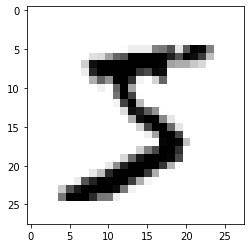

In [8]:
plt.imshow(image.reshape((28,28)), cmap='gist_yarg')

### The code below what it does is split the data in the batches
#### The train in packets of 100 and the test in batches of 500

In [8]:
torch.manual_seed(101)
# the suffle is for the network don't learn first one number and then the other because normally these datasets are organized
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


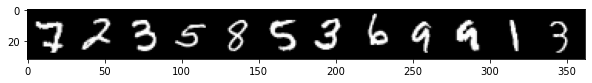

In [10]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array "formatting"

# first batch
# the break is for getting the first space
for images, labels in train_loader:
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [9]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1) # multi class problem

In [10]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
num_params = 0
for param in model.parameters():
    num_params += param.numel()
    print(param.numel())
num_params

94080
120
10080
84
840
10


105214

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# reshape the images to [100. 784] format combining the last three
print(images.shape)

images = images.view(100, -1)
print(images.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])


### Training the model

In [16]:
import time
start_time = time.time()

# train
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # this is a batch
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        # ten nuerons of output
        # [0.2, 0.1, ....., 0.9] --> 9
        # it transform the probabilities into a values

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f'Epoch {i}   batch {b}   loss:{loss.item()}   accuracy {acc}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted==y_test).sum()


    loss = criterion (y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

Epoch 0   batch 200   loss:0.2354130893945694   accuracy83.25
Epoch 0   batch 400   loss:0.3537280559539795   accuracy87.5275
Epoch 0   batch 600   loss:0.13648736476898193   accuracy89.57333333333334
Epoch 1   batch 200   loss:0.24467898905277252   accuracy94.805
Epoch 1   batch 400   loss:0.14542990922927856   accuracy95.0625
Epoch 1   batch 600   loss:0.07299499213695526   accuracy95.35666666666667
Epoch 2   batch 200   loss:0.08716949820518494   accuracy96.5
Epoch 2   batch 400   loss:0.0669819787144661   accuracy96.595
Epoch 2   batch 600   loss:0.06888754665851593   accuracy96.67833333333333
Epoch 3   batch 200   loss:0.11644277721643448   accuracy97.665
Epoch 3   batch 400   loss:0.058142390102148056   accuracy97.485
Epoch 3   batch 600   loss:0.03187106177210808   accuracy97.49666666666667
Epoch 4   batch 200   loss:0.11606234312057495   accuracy98.115
Epoch 4   batch 400   loss:0.04627266898751259   accuracy97.975
Epoch 4   batch 600   loss:0.052832409739494324   accuracy97.98

In [ ]:
# save of colab
if platform.system() == 'Linux':
  torch.save(model.state_dict(), '/content/drive/MyDrive/deep learning/pytorch_course/my files/rnc/ANN_MNIST.pt')
else:
  torch.save(model.state_dict(), 'ANN_MNIST.pt')

In [ ]:
model = model = MultilayerPerceptron()

# load the model
if platform.system() == 'Linux':
  model.load_state_dict(torch.load('/content/drive/MyDrive/deep learning/pytorch_course/my files/rna/ANN_MNIST.pt'))
else:
  model.load_state_dict(torch.load('ANN_MNIST.pt'))


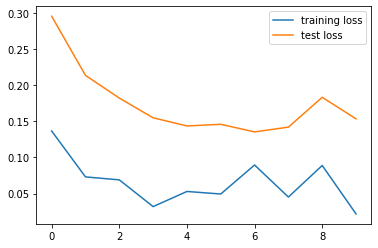

In [17]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [19]:
train_acc = [t/600 for t in train_correct]
test_acc = [t/600 for t in test_correct]

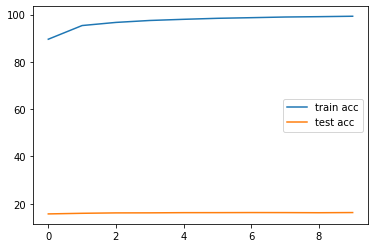

In [20]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()

### New unseen data

In [21]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [22]:
with torch.no_grad():
    correct = 0

    for X_test, y_test, in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted==y_test).sum()

In [23]:
print(f'Accuracy for the test data {100*correct.item()/len(test_data)}%')

Accuracy for the test data 97.81%


In [24]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 971,    0,    5,    0,    1,    2,    5,    2,    4,    2],
       [   0, 1120,    3,    0,    0,    0,    3,    6,    0,    2],
       [   0,    3, 1003,    2,    1,    0,    1,    9,    2,    0],
       [   2,    3,    5,  988,    0,   10,    1,    2,    4,    3],
       [   2,    0,    2,    0,  962,    2,    3,    3,    3,    8],
       [   0,    0,    0,    9,    0,  868,    2,    1,    3,    2],
       [   1,    2,    1,    0,    6,    4,  941,    0,    1,    0],
       [   0,    0,    3,    4,    1,    0,    0,  989,    2,    0],
       [   3,    7,   10,    2,    1,    5,    2,    2,  950,    3],
       [   1,    0,    0,    5,   10,    1,    0,   14,    5,  989]])